In [1]:
input_model = 'distilbert'

In [2]:
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [3]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.63 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.1 MB/s eta 0:00:00
 

In [5]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

from transformers import logging
logging.set_verbosity_error()

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [6]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 512 #512 #800

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 512 #512

# Max embeddings in BERT
DISTILBERT_MAX_EMBEDDINGS = 512 #512 #1024

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [7]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.26.4
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.1.4
sklearn version: 1.3.2


In [8]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [9]:
rdt_trainfile = f'{BASE_PATH}/Reddit/both_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/both_test.csv'
rdt_valfile = f'{BASE_PATH}/Reddit/both_val.csv'

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)
rdt_val = pd.read_csv(rdt_valfile)

In [10]:
rdt_train["text"] = rdt_train.title + " " + rdt_train.post
rdt_test["text"] = rdt_test.title + " " + rdt_test.post
rdt_val["text"] = rdt_val.title + " " + rdt_val.post

In [11]:
rdt_train

,ID,title,post,class_name,class_id,text
0,691324c4-5c30-44e0-b9e4-45b4f0715e21,a question about the third conditional.,i was making questions for my students and i r...,none,5,a question about the third conditional. i was ...
1,d4295391-9ca5-4398-b7c8-687e4a984ef1,the epitome of my life,i've recently requested testing accommodations...,adhd,0,the epitome of my life i've recently requested...
2,58937fa5-3c2c-426b-8255-5a140fbab675,what are your favourites offbeat destinations ...,**cambodia** * koh rong: amazing beaches and a...,none,5,what are your favourites offbeat destinations ...
3,7daf364c-3b33-4cbe-be37-a214edf9a73e,synesthesia survey (what colour is each month ...,synesthesia. what is synesthesia? according to...,none,5,synesthesia survey (what colour is each month ...
4,22518271-4bb4-4caf-b683-7305da519288,"science ama series: i’m phil baran, and i’m he...",i’m phil baran and i teach organic chemistry a...,none,5,"science ama series: i’m phil baran, and i’m he..."
...,...,...,...,...,...,...
13722,386a4117-0324-4b25-8330-b1a6857ccaa6,trying to wake up and leave the house every mo...,"i don't often succeed and when i do, it's like...",bipolar,2,trying to wake up and leave the house every mo...
13723,4dd92d63-1231-410d-b049-5d8c430c2f36,"""hey man, what'd you do this past weekend?""",fuck i hate this question. fuck off. i got hom...,depression,3,"""hey man, what'd you do this past weekend?"" fu..."
13724,dbde1d3e-e527-4cf8-8045-2093aec2a784,"how to use "" whereby "" correctly?",hi. i'm not a native speaker and not a good en...,none,5,"how to use "" whereby "" correctly? hi. i'm not ..."
13725,5355fad6-5bb4-4092-8428-9b8527a6d261,"i'm sorry, another depression post",i'm sorry to be such a downer all the time. i ...,bipolar,2,"i'm sorry, another depression post i'm sorry t..."


In [12]:
rdt_test

,ID,title,post,class_name,class_id,text
0,b07b978c-7760-4932-85cb-5797b5e74168,"basic needs for neurotypicals : food, clothing...",most people able to be productive and function...,adhd,0,"basic needs for neurotypicals : food, clothing..."
1,b2868fd2-e885-400e-b780-446c9581b1f1,"""you're just an iphone in an android world.: d...",i'm 23f and recently quit my job as a features...,adhd,0,"""you're just an iphone in an android world.: d..."
2,3191b3b1-d355-41b6-9588-caeb3e169c9b,"""what kind of music do you listen to?"" no answer",i just got finished with an interview and as t...,adhd,0,"""what kind of music do you listen to?"" no answ..."
3,a3d60895-ef7c-4b57-b5be-632c9fd62150,couldn’t help crying while reading a post that...,off course i’ve forgotten what i exactly read....,adhd,0,couldn’t help crying while reading a post that...
4,66fae18e-e744-495f-b7a0-b985543f5052,shout-out to all the parents with adhd childre...,"i have six siblings, and at least 4 of us have...",adhd,0,shout-out to all the parents with adhd childre...
...,...,...,...,...,...,...
1483,5855d35b-bf7d-4a49-8030-b185f430f05a,i went on a solo motorcycle ride from tamil na...,i quit my job early this year and moved back t...,none,5,i went on a solo motorcycle ride from tamil na...
1484,a2faea38-8b93-43da-a75b-cb7c0ba1ae0d,hello and namaste to r/india... from r/nepal. ...,there are lots of trolls trying to create a di...,none,5,hello and namaste to r/india... from r/nepal. ...
1485,7ad72b7f-eba4-4c17-90b0-1038dc144a8b,public api for the largest video game database...,&amp;#x200b; rawg is the largest video game da...,none,5,public api for the largest video game database...
1486,e73c198f-5e8e-4c84-aedf-333b576f9939,acs ama: hi reddit! my name is dr. john m news...,hi reddit! i’m [dr. john m. and i serve as ceo...,none,5,acs ama: hi reddit! my name is dr. john m news...


In [13]:
rdt_val

,ID,title,post,class_name,class_id,text
0,34db02f0-82ed-43e9-ac8b-65db8ba55a95,do others feel like they have a warped sense o...,i have read others talking about how add/adhd ...,adhd,0,do others feel like they have a warped sense o...
1,f515fc3a-0f62-4203-bfc8-53a8252a8fc1,do you ever feel like one small failure can de...,"last night, i thought i had enough time to fin...",adhd,0,do you ever feel like one small failure can de...
2,93ed44ff-20b8-4bc2-b71b-6c7a39fa4775,so you've heard about getting a song in your h...,... random words in your head that won't go aw...,adhd,0,so you've heard about getting a song in your h...
3,e9ec2f5b-f709-40c4-b4f2-202ebbe5bc87,anyone here have listening comprehension probl...,"it's like i can hear what people say, but ofte...",adhd,0,anyone here have listening comprehension probl...
4,2e6f28e3-acbe-44ac-82f0-a980aa07a464,i finally found a way to wake my ass up in the...,not sure if i'm alone in struggling to get out...,adhd,0,i finally found a way to wake my ass up in the...
...,...,...,...,...,...,...
1483,55acf4ff-e555-4804-8a15-b3e9a27aecbc,psa: wear earplugs to concerts.,i just turned 30 this year and a lot of my con...,none,5,psa: wear earplugs to concerts. i just turned ...
1484,b4821450-78a9-4fde-8da0-9e99a39a49db,as a cop that worked the may day protests (and...,i’ve had that opportunity to speak with dozens...,none,5,as a cop that worked the may day protests (and...
1485,d0cea880-458c-41ad-a464-82183fca0bd5,how to increase your listening skills?,what do you people are doing to increase your ...,none,5,how to increase your listening skills? what do...
1486,7346a22c-4f59-459c-815b-f3c79e67a8fa,i'm in treatment for drugs and alcohol and wou...,here's the deal. i'm in treatment for drugs an...,none,5,i'm in treatment for drugs and alcohol and wou...


In [14]:
# Shuffle all rows
# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)
rdt_val = rdt_val.sample(frac=1).reset_index(drop=True)


# Split data into test and train
#train_size = int(0.8 * len(rdt_train))
# train_size = int(len(rdt_train))
X_train = rdt_train.text
X_val = rdt_val.text
X_test = rdt_test.text
y_train = rdt_train.class_id
y_val = rdt_val.class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


In [15]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['depression' 'none' 'adhd' 'ptsd' 'anxiety' 'bipolar']


array([3, 5, 0, 4, 1, 2])

In [16]:
print(rdt_val.class_name.unique())
rdt_val.class_id.unique()

['depression' 'ptsd' 'anxiety' 'bipolar' 'none' 'adhd']


array([3, 4, 1, 2, 5, 0])

In [17]:
print(rdt_test.class_name.unique())
rdt_test.class_id.unique()

['none' 'ptsd' 'depression' 'anxiety' 'adhd' 'bipolar']


array([5, 4, 3, 1, 0, 2])

In [18]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

# print('Distribution of the length of all posts')
# print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (13727,)
Validation set labels shape: (1488,)
Test set labels shape: (1488,)
Training set examples shape: (13727,)
Validation set examples shape: (1488,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Labels min : 0 max : 5


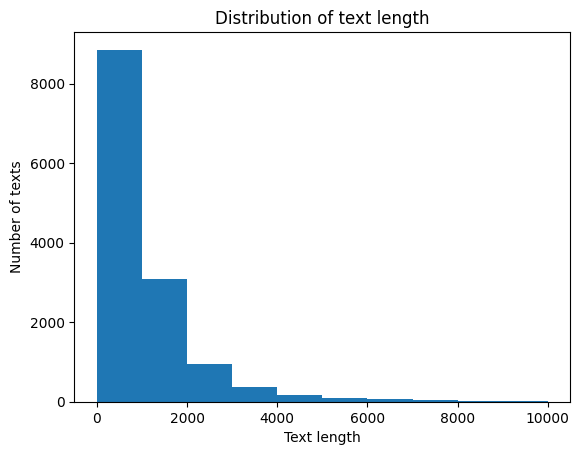

In [19]:
#@ Histogram of all text length
plt.hist(rdt_train["text"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of text length')
plt.xlabel('Text length')
plt.ylabel('Number of texts')
plt.show()

In [20]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 2465/13727 (0.17957310410140598)
Labels 1 in training set: 2422/13727 (0.17644059153493116)
Labels 2 in training set: 2407/13727 (0.17534785459313762)
Labels 3 in training set: 2450/13727 (0.17848036715961244)
Labels 4 in training set: 2001/13727 (0.14577110803525897)
Labels 0 in validation set: 248/1488 (0.16666666666666666)
Labels 1 in validation set: 248/1488 (0.16666666666666666)
Labels 2 in validation set: 248/1488 (0.16666666666666666)
Labels 3 in validation set: 248/1488 (0.16666666666666666)
Labels 4 in validation set: 248/1488 (0.16666666666666666)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [21]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{3: 'depression', 5: 'none', 0: 'adhd', 4: 'ptsd', 1: 'anxiety', 2: 'bipolar'}
{'depression': 3, 'none': 5, 'adhd': 0, 'ptsd': 4, 'anxiety': 1, 'bipolar': 2}


In [22]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

In [23]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

In [ ]:
# #@title BERT Tokenization of training, validation and test data

# def tokenize_test(tokenizer, test_examples):

#     test_examples_str = [x for x in test_examples]

#     # Tokenize training, validation and test data
#     bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

#     bert_test_inputs = [bert_test_tokenized.input_ids,
#                         bert_test_tokenized.token_type_ids,
#                         bert_test_tokenized.attention_mask]


#     return bert_test_inputs

In [24]:


def distilbert_main(train, val, tlabels, vlabels, fraction,
                    max_sequence_length=MAX_SEQUENCE_LENGTH,
                    hidden_size = 100,
                    dropout=0.3,
                    learning_rate=0.00005):
    """
    Main function to train distilbert model
    """

    LEARNING_RATE = 5e-5
    BATCH_SIZE = 8
    NUM_EPOCHS = 2

    NUM_LABELS = np.max(tlabels) + 1

    config_l = DistilBertConfig.from_pretrained("distilbert-base-uncased")
    config_l.num_max_position_embeddingslabels = DISTILBERT_MAX_EMBEDDINGS
    config_l.num_labels = NUM_LABELS
    base_model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', config = config_l)
    #base_model = TFDistilBertForSequenceClassification.from_pretrained(
    #    'distilbert-base-uncased', num_labels = NUM_LABELS)

    # Load training, validation and test data
    tsamples = train[0:int(fraction*len(train))]
    train_samples = tsamples.tolist()
    vsamples = val[0:int(fraction*len(val))]
    val_samples = vsamples.tolist()

    # Convert labels to numpy arrays
    train_labels = np.array(tlabels)
    train_sample_labels = train_labels[0:int(fraction*len(tlabels))]

    val_labels = np.array(vlabels)
    val_sample_labels = val_labels[0:int(fraction*len(vlabels))]

    # Tokenize training, validation and test data
    distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, train_samples)),  # Convert BatchEncoding instance to dictionary
        train_sample_labels)).shuffle(1000).batch(BATCH_SIZE).prefetch(1)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, val_samples)),  # Convert BatchEncoding instance to dictionary
        val_sample_labels)).batch(BATCH_SIZE).prefetch(1)

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                 metrics='accuracy')

    base_model.summary()

    model_history = base_model.fit(
        train_dataset,
        y=None,
        validation_data=val_dataset,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS)

    return base_model, model_history



In [25]:
fraction = 1

In [26]:
model, model_history = distilbert_main(train_examples, val_examples, train_labels, val_labels, fraction)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
1716/1716 [=========================

In [27]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
test_examples_list = test_examples.tolist()
test_tokens = tokenize_data(distilbert_tokenizer, test_examples_list)
y_prediction = model.predict((dict(test_tokens),)) # Pass a tuple to predict
# Extract the NumPy array from the dictionary
y_prediction = y_prediction[0] # Extract the NumPy array

47/47 [==============================] - 8s 128ms/step


In [28]:
# Convert predicted probabilities to class labels
y_pred_label = np.argmax(y_prediction, axis=1)

	 Printing confusion matrix


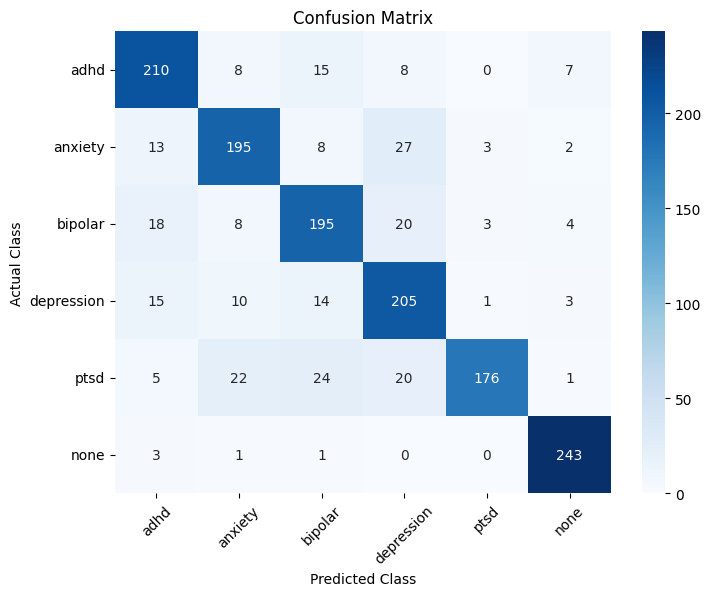

Accuracy: 0.8225806451612904
              precision    recall  f1-score   support

        adhd       0.80      0.85      0.82       248
     anxiety       0.80      0.79      0.79       248
     bipolar       0.76      0.79      0.77       248
  depression       0.73      0.83      0.78       248
        ptsd       0.96      0.71      0.82       248
        none       0.93      0.98      0.96       248

    accuracy                           0.82      1488
   macro avg       0.83      0.82      0.82      1488
weighted avg       0.83      0.82      0.82      1488



In [29]:
from sklearn.metrics import confusion_matrix
print('\t Printing confusion matrix')
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test_labels, y_pred_label)

# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(actuals_names)) + 0.5, labels=actuals_names, rotation=45)
plt.yticks(ticks=np.arange(len(predictions_names)) + 0.5, labels=predictions_names, rotation=0)

# Add labels, title, and color bar
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, y_pred_label)}')

print(classification_report(test_labels, y_pred_label, target_names=predictions_names))

In [ ]:
# Accuracy: 0.6827956989247311
#               precision    recall  f1-score   support

#         adhd       0.72      0.73      0.72       248
#      anxiety       0.48      0.79      0.60       248
#      bipolar       0.64      0.51      0.57       248
#   depression       0.66      0.66      0.66       248
#         ptsd       0.85      0.51      0.64       248
#         none       0.93      0.90      0.91       248

#     accuracy                           0.68      1488
#    macro avg       0.71      0.68      0.68      1488
# weighted avg       0.71      0.68      0.68      1488

In [30]:
fraction

1

In [31]:
print('\t Saving all mismatches')
# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

mismatches = []
for i in range(len(test_labels)):
    if test_labels[i] != y_pred_label[i]:
        id1 = test_labels[i]
        id2 = y_pred_label[i]
        entry = {}
        entry['actual'] = actuals_names[id1]
        entry['predicted'] = predictions_names[id2]
        entry['test_id'] = i
        entry['text'] = test_examples[i]
        mismatches.append(entry)
df = pd.DataFrame(mismatches)
df.to_csv('drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/mismatches_distilbert_combination.csv', index=False)


	 Saving all mismatches
